# Hackaton

In [ ]:
!apt-get install -y build-essential python3-dev
!pip install -q -U pystan==2.19.1.1
!pip install -q -U prophet

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
python3-dev is already the newest version (3.10.6-1~22.04.1).
python3-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 89.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pystan
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pystan)


In [ ]:
!pip install -q -U tslearn
!pip install -q -U --upgrade pip
!pip install -q -U tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 136.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [ ]:
!pip install openpyxl

In [ ]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow import group
from tensorflow.python.keras.utils.np_utils import normalize
from sklearn.preprocessing import MinMaxScaler
from tslearn.clustering import TimeSeriesKMeans
from keras.layers import LSTM, Dropout, Dense, SimpleRNN, Bidirectional

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def compute_elbow(df, max_clusters=7):
    """
    Compute the elbow method for determining the optimal number of clusters using DTW and K-means.

    Args:
        df (pd.DataFrame): The input DataFrame containing time series data.
        max_clusters (int): The maximum number of clusters to test.
    """
    # Normalize
    df = normalize(df)
    # Reshape the DataFrame into time series data
    time_series_data = df.values.reshape((df.shape[0], df.shape[1], 1))
    print(f'Shape of time_series_data: {time_series_data.shape}')

    inertia = []
    k_values = range(1, max_clusters + 1)

    for k in k_values:
        model = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=42)
        model.fit(time_series_data)
        inertia.append(model.inertia_)
        print(f'Completed {k} cluster/s')

    # Plotting the elbow
    plt.figure(figsize=(12, 6))
    plt.plot(k_values, inertia, marker='o')
    plt.title('Elbow using DTW & K-means')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.xticks(k_values)  # Optionally show all k values
    plt.grid()
    plt.show()

    return (time_series_data)

In [ ]:
def process_ISE(df):
    """
    Processes the given DataFrame by filling NaN values,
    concatenating the first two rows, and resetting the index.

    Args:
        df (pd.DataFrame): The DataFrame to process.

    Returns:
        pd.DataFrame: The processed DataFrame.
    """

    # Fill forward NaN values along each row (axis=1)
    df.ffill(axis=1, inplace=True)

    # Create a new Series by concatenating the first and second rows as strings
    concatenated_row = (df.iloc[0].astype(str) + ' ' + df.iloc[1].astype(str))

    # Create a new DataFrame from the concatenated row
    new_df = pd.DataFrame([concatenated_row])

    # Concatenate the new DataFrame with the remaining rows, dropping the first two rows
    df = pd.concat([new_df, df.drop(index=[0, 1])], ignore_index=True)

    # Drop any rows with NaN values (if needed; this step is optional)
    df.dropna(inplace=True)

    # Set the first row of the DataFrame as the new column headers
    df.columns = df.iloc[0]

    # Remove the first row now that it has been set as the header
    df = df[1:]

    # Reset the index of the DataFrame, dropping the old index
    df.reset_index(drop=True, inplace=True)

    return df


In [ ]:
def normalize(df):
    """
    Cleans the input DataFrame by dropping specified columns, normalizing the entire dataset collectively,
    and returning the cleaned and normalized DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame containing time series data.

    Returns:
        pd.DataFrame: The cleaned and normalized DataFrame.
    """

    # Flatten the DataFrame to a 1D array for collective normalization
    df = df.loc[:, (df != 0).any(axis=0)]
    df.columns = df.columns.astype('int32')
    flattened_data = df.values.flatten().reshape(-1, 1).astype(float)

    # Normalize the entire dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_flattened_data = scaler.fit_transform(flattened_data)

    # Reshape back to original shape
    normalized_data = normalized_flattened_data.reshape(df.shape)

    # Convert the normalized data back into a DataFrame
    normalized_df = pd.DataFrame(normalized_data, columns=df.columns)
    normalized_df.reset_index(drop=True, inplace=True)


    return normalized_df.reset_index(drop=True), scaler

In [ ]:
# prompt: create a function for this that replace the KNETO con un input
# # Filter KNETO imp_MARO
# knet_columns = [col for col in imp_MARO.columns if col.startswith('KNETO')]
# knet_imp_MARO_df = imp_MARO[knet_columns]
# knet_imp_MARO_df.columns = [col.split()[1] for col in knet_imp_MARO_df.columns]
# knet_imp_MARO_df = knet_imp_MARO_df.iloc[:, :-2]
# knet_imp_MARO_df.head(5)

def filter_dataframe(df, prefix):
  """
  Filters a DataFrame based on a specified column prefix,
  extracts columns with that prefix, renames the columns,
  and removes the last two columns.

  Args:
      df (pd.DataFrame): The input DataFrame.
      prefix (str): The prefix to filter columns by.

  Returns:
      pd.DataFrame: The filtered and processed DataFrame.
  """
  columns_to_filter = [col for col in df.columns if col.startswith(prefix)]
  filtered_df = df[columns_to_filter]
  filtered_df.columns = [col.split()[1] for col in filtered_df.columns]
  filtered_df = filtered_df.iloc[:, :-2]
  return filtered_df

In [ ]:
def process_ipp_df(df):
  """
  Processes the IPP DataFrame by dropping specific columns,
  removing columns with certain patterns, and renaming columns
  with a date sequence.

  Args:
      df (pd.DataFrame): The input DataFrame.

  Returns:
      pd.DataFrame: The processed DataFrame.
  """
  try:
    codigo = input("Ingrese CIIU: ")
    if codigo in df['CODIGO'].values:
      f = df[df['CODIGO'] == codigo]['DESCRIPTIVA'].values[0]
      print(f'La clase {f}fue encontrada')
      df = df[df['CODIGO'] == codigo]

      # Drop specified columns
      IPP_df = df.drop(columns=['NIVEL', 'CODIGO', 'DESCRIPTIVA'])
      IPP_df = IPP_df.loc[:, ~IPP_df.columns.str.contains(r'\(pr\)\*')]
      IPP_df = IPP_df.loc[:, ~IPP_df.columns.str.contains(r'\(pr\*\)')]
      # Define yr
      start_month = 12
      start_year = 2014
      date_sequence = []

      for i in range(len(IPP_df.columns)):
          date_sequence.append(pd.Timestamp(year=start_year, month=start_month, day=1))
          start_month += 1
          if start_month > 12:
              start_month = 1
              start_year += 1

      IPP_df.columns = date_sequence
      IPP_df.dropna(inplace=True)

      IPP_T = IPP_df.transpose()
      IPP_T['Date'] = IPP_T.index
      IPP_T.reset_index(drop=True, inplace=True)
      IPP_T = IPP_T[['Date'] + [col for col in IPP_T.columns if col != 'Date']]

      return IPP_T

    else:
      print('Codigo inválido')
      process_ipp_df(df)

  except:
    print('inválido')


In [ ]:
import pandas as pd

def process_ipc(df):
    # Create a dictionary to map Spanish months to their English equivalent
    spanish_months = {
        'Enero': 'January', 'Febrero': 'February', 'Marzo': 'March', 'Abril': 'April',
        'Mayo': 'May', 'Junio': 'June', 'Julio': 'July', 'Agosto': 'August',
        'Septiembre': 'September', 'Octubre': 'October', 'Noviembre': 'November', 'Diciembre': 'December'
    }

    # Replace the Spanish month names with their English equivalents
    df['Mes'] = df['Mes'].replace(spanish_months)

    # Combine the 'Año' (Year) and 'Mes' (Month) columns into a single 'Date' column
    df['Date'] = pd.to_datetime(df['Año'].astype(str) + ' ' + df['Mes'], format='%Y %B')

    # Drop the original 'Año' and 'Mes' columns
    df = df.drop(columns=['Año', 'Mes'])

    # Reorganize the columns so 'Date' is the first column
    df = df[['Date', 'Índice']]

    return df



In [ ]:
def process_ise(df):
  """
  Processes the ISE DataFrame by dropping specific columns,
  removing columns with certain patterns, and renaming columns
  with a date sequence.

  Args:
      df (pd.DataFrame): The input DataFrame.

  Returns:
      pd.DataFrame: The processed DataFrame.
  """
    # Define yr
  start_month = 1
  start_year = 2005
  date_sequence = []

  for i in range(len(df.columns)):
      date_sequence.append(pd.Timestamp(year=start_year, month=start_month, day=1))
      start_month += 1
      if start_month > 12:
          start_month = 1
          start_year += 1

  df.columns = date_sequence
  df.dropna(inplace=True)
  # IPP_df = IPP_df.T.groupby(IPP_df.T.index.year).mean().T

  return df

In [ ]:
def process_ipc_data(df):
    """
    Function to process IPC data from an Excel file and convert it into a time series format
    with dates in datetime format without changing locale.

    Parameters:
    - file_path (str): The path to the Excel file containing the IPC data.

    Returns:
    - pd.DataFrame: A DataFrame with two columns:
        - 'Fecha' (datetime): The date as a datetime object (month/year).
        - 'Indice' (float): The corresponding index value.
    """


   # Dictionary to map Spanish month names to month numbers
    month_map = {
        'Enero': '01',
        'Febrero': '02',
        'Marzo': '03',
        'Abril': '04',
        'Mayo': '05',
        'Junio': '06',
        'Julio': '07',
        'Agosto': '08',
        'Septiembre': '09',
        'Octubre': '10',
        'Noviembre': '11',
        'Diciembre': '12'
    }

    # Map the month names to their corresponding numbers
    df['Mes'] = df['Mes'].map(month_map)

    # Reshape the DataFrame from wide to long format
    df_melt = pd.melt(df, id_vars=['Mes'], var_name='Año', value_name='Indice')

    # Combine 'Mes' and 'Año' into a 'Fecha' column in datetime format
    df_melt['Date'] = pd.to_datetime(df_melt['Año'].astype(str) + '-' + df_melt['Mes'], format='%Y-%m', errors='coerce')

    # Select only 'Fecha' and 'Indice' columns, sort them, and reset the index
    df_melt = df_melt[['Date', 'Indice']].sort_values(by='Date').reset_index(drop=True)

    return df_melt.dropna().reset_index(drop=True)




# Carga de datos


In [ ]:
# Load datasets
ventas_MARO = pd.read_excel('/content/drive/MyDrive/Hackaton_TT/ccb_hackaton/data/ventas_MARO.xlsx', skiprows=8)
imp_MARO = pd.read_excel('/content/drive/MyDrive/Hackaton_TT/ccb_hackaton/data/imp_MARO.xlsx', skiprows=10)
imp_MARO = imp_MARO.groupby(imp_MARO.columns[1]).sum()
exp_MARO = pd.read_excel('/content/drive/MyDrive/Hackaton_TT/ccb_hackaton/data/exp_MARO.xlsx', skiprows=9)
exp_MARO = exp_MARO.groupby(exp_MARO.columns[1]).sum()
prod_MARO = pd.read_excel('/content/drive/MyDrive/Hackaton_TT/ccb_hackaton/data/prod_MARO.xlsx', skiprows=9)
prod_MARO = prod_MARO.groupby(exp_MARO.columns[1]).sum()
IPP = pd.read_excel('/content/drive/MyDrive/Hackaton_TT/ccb_hackaton/data/IPP.xlsx', sheet_name='1.1', skiprows=5).iloc[:-7]
ISE = process_ISE(pd.read_excel('/content/drive/MyDrive/Hackaton_TT/ccb_hackaton/data/ISE.xlsx', sheet_name='Cuadro 1', skiprows=9))[:-48].reset_index(drop=True)
# IPC = pd.read_excel('/content/drive/MyDrive/Hackaton_TT/ccb_hackaton/data/IPC.xlsx', sheet_name='13',
#                                     skiprows=6).iloc[:-5][['Año', 'Mes', 'Índice']].dropna()


In [ ]:
IPC = process_ipc_data(pd.read_excel('/content/drive/MyDrive/Hackaton_TT/ccb_hackaton/data/IPC_1.xlsx',skiprows=8).iloc[:-5])


<ipython-input-13-4c5f588a0a1f>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mes'] = df['Mes'].map(month_map)


# Ingeniería de características

In [ ]:
ventas_MARO_df  , scaler_ventas  = normalize(ventas_MARO.drop(ventas_MARO.columns[0:3], axis=1))
knet_imp_MARO_df, scaler_imp_knet  = normalize(filter_dataframe(imp_MARO, 'KNETO'))
cif_imp_MARO_df , scaler_imp_cif  = normalize(filter_dataframe(imp_MARO, 'CIF'))
fob_imp_MARO_df , scaler_imp_fob  = normalize(filter_dataframe(imp_MARO, 'FOB'))
knet_exp_MARO_df, scaler_exp_knet  = normalize(filter_dataframe(exp_MARO, 'KNETO'))
fob_exp_MARO_df , scaler_exp_fob  = normalize(filter_dataframe(exp_MARO, 'FOB'))
# ISE_df            = process_ise(ISE.drop(ISE.columns[0]).iloc[-1:].reset_index(drop=True))
IPP_df            = process_ipp_df(IPP)
IPC_df            = IPC

Ingrese CIIU: 2100
La clase Fabricación de productos farmacéuticos, sustancias químicas medicinales y productos botánicos de uso fue encontrada


# Entrenamiento IPC IPP

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def preprocess_data_for_lstm(df, window_size=60, feature_range=(0, 1),sc = True):
    """
    Preprocesses a DataFrame for LSTM training:
    1. Selects numeric columns.
    2. Normalizes using MinMaxScaler.
    3. Creates time sequences.

    Parameters:
    df (pd.DataFrame): The input data.
    window_size (int): The size of the time window for sequences.
    feature_range (tuple): The feature range for MinMaxScaler.

    Returns:
    X (np.array): Preprocessed feature sequences for LSTM.
    y (np.array): Target sequences for LSTM.
    scaler (MinMaxScaler): Scaler fitted on the data (for inverse transformation if needed).
    """
    # Select numeric columns
    df_numeric = df.select_dtypes(include=[np.number])
    if sc:
        # Normalize
        scaler = MinMaxScaler(feature_range=feature_range)
        scaled_data = scaler.fit_transform(df_numeric)
        df_scaled = pd.DataFrame(scaled_data, index=df.index, columns=df_numeric.columns)
    else:
        df_scaled = df
        scaler = None
    # Create time sequences
    X, y = [], []
    for i in range(len(df_scaled) - window_size):
        X.append(df_scaled.values[i:i + window_size])
        y.append(df_scaled.values[i + window_size])
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Reshape X for LSTM (n_samples, timesteps, n_features)
    n_features = X.shape[2]
    X = X.reshape((X.shape[0], X.shape[1], n_features))

    return df_scaled, X, y, scaler


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import TimeSeriesSplit

def train_and_evaluate_model(X, y, n_splits=3, epochs=20, batch_size=32, n_features=1):
    """
    Trains and evaluates an LSTM model using TimeSeriesSplit cross-validation.

    Parameters:
    X (np.array): The feature set.
    y (np.array): The target set.
    n_splits (int): The number of splits for cross-validation.
    epochs (int): The number of epochs for training.
    batch_size (int): The batch size for training.
    n_features (int): The number of features in the dataset.

    Returns:
    None
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)

    for train_index, test_index in tscv.split(X):
        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Create and compile the LSTM model
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], n_features)))
        model.add(Dropout(0.3))
        model.add(LSTM(units=50))
        model.add(Dropout(0.3))
        model.add(Dense(units=n_features))
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Train the model
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

        # Evaluate the model
        loss = model.evaluate(X_test, y_test)
        print("Test Loss:", loss)


In [ ]:
def predict_next_values(model, scaler, scaled_data, window_size, num_steps):
    """
    Predict the next several values of a time series.

    Parameters:
        model (keras.Model): The trained model used for prediction.
        scaler (sklearn.preprocessing.Scaler): The scaler to inverse transform the predicted data.
        scaled_data (numpy.ndarray): The scaled time series data.
        window_size (int): The number of time steps used for the prediction.
        num_steps (int): The number of future time steps to predict.

    Returns:
        numpy.ndarray: The predicted future values in the original scale.
    """
    # Prepare the last window of data
    last_window = scaled_data.values[-window_size:]
    last_window = last_window.reshape((1, last_window.shape[0], last_window.shape[1]))

    predictions = []

    for _ in range(num_steps):
        # Predict the next scaled value
        pred_scaled = model.predict(last_window)

        # Inverse transform to get the prediction in original scale
        pred_original = scaler.inverse_transform(pred_scaled)

        # Store the prediction
        predictions.append(pred_original[0, 0])  # assuming pred_original is of shape (1, 1)

        # Update the last_window by adding the predicted value and removing the oldest one
        last_window = np.append(last_window[:, 1:, :], pred_scaled.reshape(1, 1, -1), axis=1)

    return np.array(predictions)


In [ ]:
def add_predictions_to_dataframe(original_df, predictions):
    """
    Add future predictions to the original dataframe.

    Parameters:
        original_df (pd.DataFrame): The original dataframe.
        predictions (numpy.ndarray): The predicted values.

    Returns:
        pd.DataFrame: Updated dataframe with predictions.
    """
    # Create a copy of the original dataframe
    df_with_predictions = original_df.copy()

    # Create a list of dates for the next periods based on the length of predictions
    last_date = df_with_predictions['Date'].max()
    periods = len(predictions)
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=periods, freq='MS')

    # Create a temporary dataframe with the predictions
    pred_df = pd.DataFrame({'Date': future_dates, original_df.columns[1]: predictions})

    # Concatenate the original dataframe with the predictions
    df_with_predictions = pd.concat([df_with_predictions, pred_df], ignore_index=True)

    return df_with_predictions


In [ ]:
# Preprocess IPC IPP
IPP_window_size = 9
IPC_window_size = 8
IPP_scaled, X_IPP, y_IPP, scaler_IPP = preprocess_data_for_lstm(IPP_df, window_size=IPP_window_size, sc=True)
IPC_scaled, X_IPC, y_IPC, scaler_IPC = preprocess_data_for_lstm(IPC_df, window_size=IPC_window_size, sc=True)


In [ ]:
# Evaluation
# train_and_evaluate_model(X_IPP, y_IPP, n_features=X_IPP.shape[2])
# train_and_evaluate_model(X_IPC, y_IPC, n_features=X_IPC.shape[2])


In [ ]:
def model_lstm_b(X_train, y_train, n):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(50, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(50)))
    model.add(Dropout(0.1))
    model.add(Dense(n))
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=20, batch_size=32)
    return model, history

In [ ]:
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dropout, Dense, BatchNormalization
from keras.optimizers import Adam

def model_lstm(X_train, y_train, n, learning_rate=0.001):  # Añadimos un parámetro para el learning rate
    model = Sequential()

    # Definir el optimizador con un learning rate personalizado
    optimizer = Adam(learning_rate=learning_rate)

    # Primera capa LSTM Bidireccional
    model.add(Bidirectional(LSTM(100, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    # Segunda capa LSTM Bidireccional
    model.add(Bidirectional(LSTM(100, return_sequences=True)))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    # Tercera capa LSTM Bidireccional
    model.add(Bidirectional(LSTM(100, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    # Capa LSTM final
    model.add(Bidirectional(LSTM(50)))  # La última capa no necesita return_sequences=True
    model.add(Dropout(0.2))

    # Capa densa de salida
    model.add(Dense(n))

    # Compilación del modelo con el optimizador personalizado
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Entrenamiento del modelo
    history = model.fit(X_train, y_train, epochs=150, batch_size=100, validation_split=0.2, shuffle=True)

    return model, history


In [ ]:
from prophet import Prophet
import pandas as pd

def fit_prophet(df, periods, changepoint_prior_scale, seasonality_prior_scale,freq):
    """
    Realiza una predicción futura utilizando el modelo Prophet en base mensual,
    manteniendo los datos originales y añadiendo solo las predicciones futuras.

    Parámetros:
        df (pd.DataFrame): DataFrame con columnas 'Date' (fechas) y la segunda columna
                           con los valores a predecir.
        periods (int): Número de meses hacia adelante que se quiere predecir.

    Retorno:
        pd.DataFrame: DataFrame con los datos originales y las predicciones futuras añadidas.
    """
    # Renombrar columnas para Prophet
    df = df.rename(columns={df.columns[0]: 'ds', df.columns[1]: 'y'})

    # Asegurar formato datetime en 'ds'
    df['ds'] = pd.to_datetime(df['ds'])

    # Inicializar y ajustar modelo Prophet
    model = Prophet(yearly_seasonality=True, changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale)
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.fit(df)

    # Crear DataFrame futuro a partir de la última fecha
    future = model.make_future_dataframe(periods=periods, freq=freq)

    # Generar predicción
    forecast = model.predict(future)

    # Filtrar para agregar solo las predicciones futuras
    forecast_future = forecast[forecast['ds'] > df['ds'].max()]

    # Unir datos originales con las predicciones futuras
    combined_df = pd.concat([df, forecast_future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]], ignore_index=True)

    # Formatear fechas para claridad (opcional)
    combined_df['ds'] = combined_df['ds'].dt.strftime('%m/%Y')

    return forecast_future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Ejemplo de uso con periodos futuros especificados
periods = 24
forecast_IPP = fit_prophet(IPP_df, periods=periods+1, changepoint_prior_scale=0.01, seasonality_prior_scale=0.01,freq='M')
forecast_IPC = fit_prophet(IPC_df, periods=periods, changepoint_prior_scale=0.001, seasonality_prior_scale=0.005,freq='M')


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5ur_kxf/muccsso1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq5ur_kxf/9qxg2gn1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2339', 'data', 'file=/tmp/tmpq5ur_kxf/muccsso1.json', 'init=/tmp/tmpq5ur_kxf/9qxg2gn1.json', 'output', 'file=/tmp/tmpq5ur_kxf/prophet_modelwasg0w2i/prophet_model-20241026114310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:43:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:43:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/p

In [ ]:
def calculate_adjusted_forecast(forecast, df, factor):
    # Convertir las fechas al formato '%Y-%m' para considerar solo año y mes
    forecast['ds'] = pd.to_datetime(forecast['ds']).dt.to_period('M').dt.to_timestamp()
    df['Date'] = pd.to_datetime(df['Date']).dt.to_period('M').dt.to_timestamp()

    # Unir los DataFrames por la fecha ajustada a mes y año
    merged_df = pd.merge(forecast, df, left_on='ds', right_on='Date', how='inner')

    # Calculamos la pendiente como la diferencia entre yhat[n+1] y yhat[n]
    merged_df['pendiente_yhat'] = merged_df['yhat'].diff()

    # Aseguramos que el primer valor sea NaN o cero (según tu preferencia)
    merged_df['pendiente_yhat'].fillna(0, inplace=True)  # Rellena NaN con 0

    # Ajustamos merged_df['yhat_avg'] conservando la escala de df.columns[1]
    merged_df['yhat_avg'] = merged_df[df.columns[1]] + factor*merged_df['pendiente_yhat']

    # Opcional: eliminar la columna temporal 'pendiente_yhat' si no se necesita
    merged_df.drop(columns=['pendiente_yhat'], inplace=True)

    # Ajustar los intervalos de confianza en función del promedio
    merged_df['yhat_lower_avg'] = merged_df['yhat_lower'] + (merged_df['yhat_avg'] - merged_df['yhat'])
    merged_df['yhat_upper_avg'] = merged_df['yhat_upper'] + (merged_df['yhat_avg'] - merged_df['yhat'])

    # Seleccionar las columnas finales en un nuevo DataFrame
    result_df = merged_df[['ds', 'yhat_avg', 'yhat_lower_avg', 'yhat_upper_avg']]

    return result_df




In [ ]:
# Train both models
model_IPP, history_IPP = model_lstm_b(X_IPP, y_IPP,1)
model_IPC, history_IPC = model_lstm_b(X_IPC, y_IPC,1)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.2751
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0350
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0397
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0099
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0179
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0099
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0088
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0068
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0053
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0055
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0054
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0049
Epoch 13/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0037
Epoch 14/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0053
Epoch 15/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0038
Epoch 16/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/

In [ ]:
# Predictions for IPP and IPC
pred_ipp = predict_next_values(model_IPP, scaler_IPP, IPP_scaled, IPP_window_size,periods+1)
pred_ipc = predict_next_values(model_IPC, scaler_IPC, IPC_scaled, IPC_window_size,periods)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

In [ ]:
ipp_df_with_predictions = add_predictions_to_dataframe(IPP_df, pred_ipp)
ipc_df_with_predictions = add_predictions_to_dataframe(IPC_df, pred_ipc)

In [ ]:
result_ipp = calculate_adjusted_forecast(forecast_IPP, ipp_df_with_predictions, factor=2)
result_ipc = calculate_adjusted_forecast(forecast_IPC, ipc_df_with_predictions, factor=0.23)

<ipython-input-26-ee0351cf2685>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['pendiente_yhat'].fillna(0, inplace=True)  # Rellena NaN con 0
<ipython-input-26-ee0351cf2685>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value

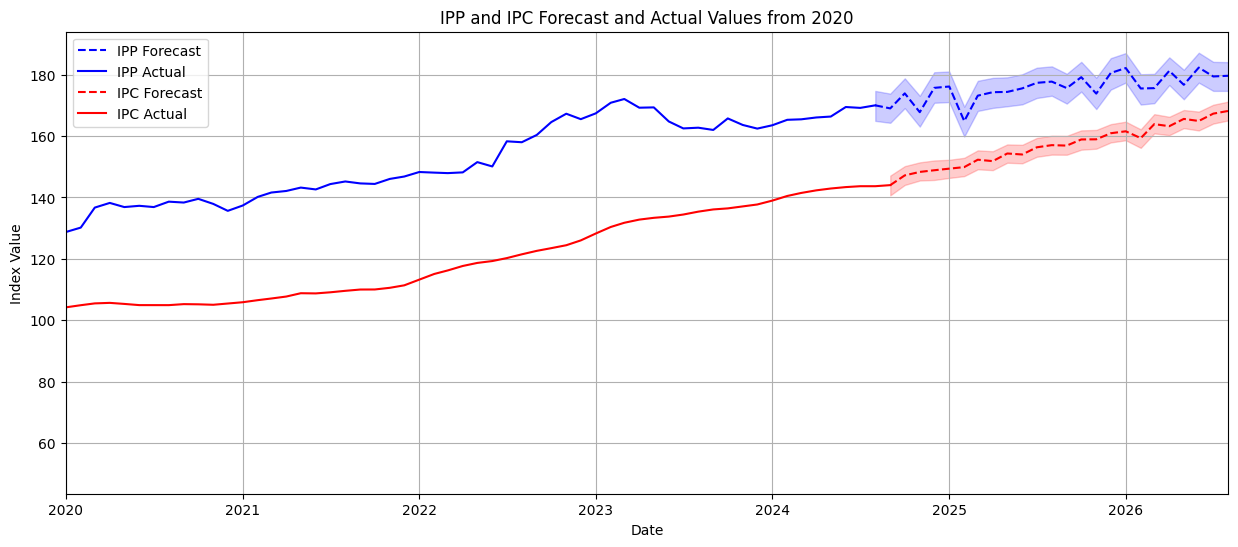

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Recorta los datos hasta n - periods
ipp_df_with_predictions_trimmed = ipp_df_with_predictions.iloc[:-periods-1]
ipc_df_with_predictions_trimmed = ipc_df_with_predictions.iloc[:-periods]

plt.figure(figsize=(15, 6))

# Plot IPP
plt.plot(result_ipp['ds'], result_ipp['yhat_avg'], label='IPP Forecast', color='blue', linestyle='--')
plt.fill_between(result_ipp['ds'], result_ipp['yhat_lower_avg'], result_ipp['yhat_upper_avg'], color='blue', alpha=0.2)
plt.plot(ipp_df_with_predictions_trimmed['Date'], ipp_df_with_predictions_trimmed[ipp_df_with_predictions_trimmed.columns[1]], label='IPP Actual', color='blue')

# Plot IPC
plt.plot(result_ipc['ds'], result_ipc['yhat_avg'], label='IPC Forecast', color='red', linestyle='--')
plt.fill_between(result_ipc['ds'], result_ipc['yhat_lower_avg'], result_ipc['yhat_upper_avg'], color='red', alpha=0.2)
plt.plot(ipc_df_with_predictions_trimmed['Date'], ipc_df_with_predictions_trimmed[ipc_df_with_predictions_trimmed.columns[1]], label='IPC Actual', color='red')

plt.xlabel('Date')
plt.ylabel('Index Value')
plt.title('IPP and IPC Forecast and Actual Values from 2020')
plt.legend()
plt.grid(True)

# Adjust the x-axis limits to start from 2020
plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime(result_ipp['ds'].max()))

plt.show()


# Entrenamiento MARO ventas

In [ ]:
# Concatenate the dataframes vertically, using axis=0
lstm_df = pd.concat([knet_imp_MARO_df, cif_imp_MARO_df,
                       fob_imp_MARO_df, knet_exp_MARO_df, fob_exp_MARO_df], axis=0).reset_index(drop=True)
cluster_df = pd.concat([ventas_MARO_df,lstm_df],axis=0).reset_index(drop=True)
# Print the merged dataframe
lstm_df.dropna(axis=1, inplace=True)
cluster_df.dropna(axis=1, inplace=True)

In [ ]:
# Reshape the DataFrame into time series data
# time_series_data = compute_elbow(cluster_df.iloc[:, :-1])

In [ ]:
ts = cluster_df
time_series_data = ts.values.reshape((ts.shape[0], ts.shape[1], 1))

In [ ]:
# Use DTW in KMeans Clustering
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", random_state=42)
clusters = model.fit_predict(time_series_data)

cluster_df['Cluster'] = clusters



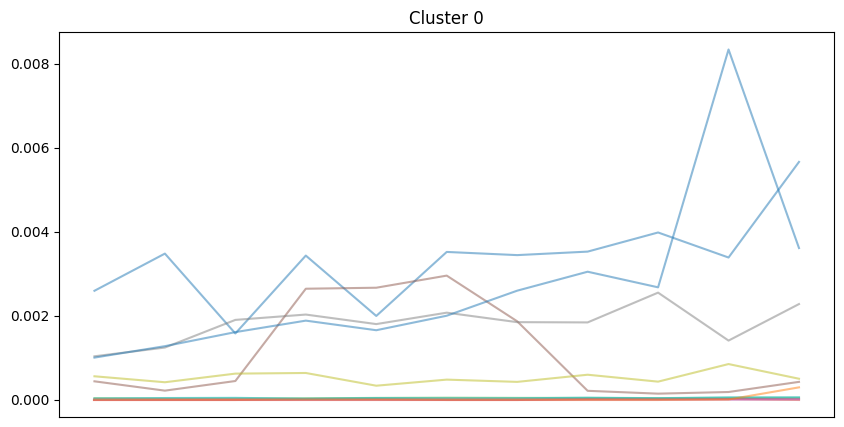

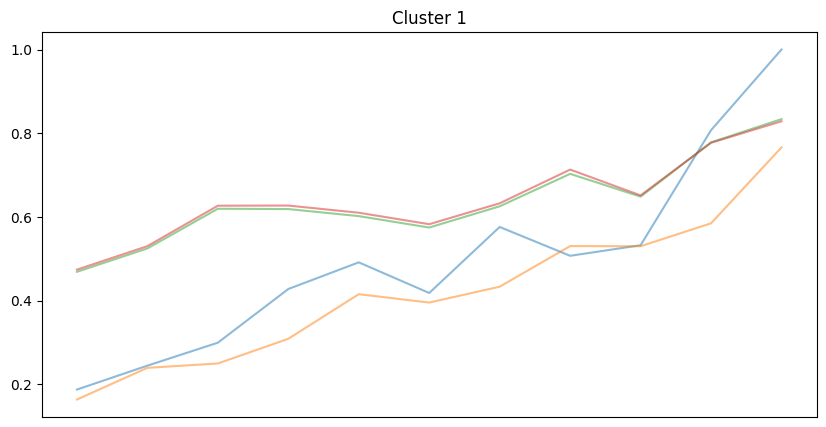

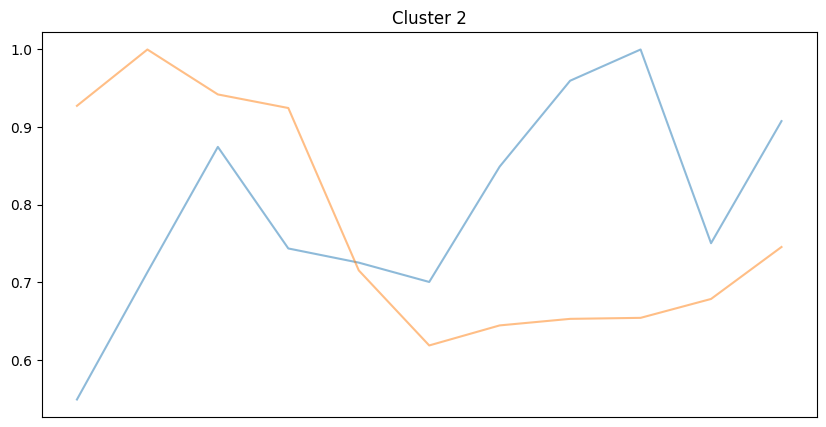

In [ ]:
# Analyzing the clusters

for cluster in np.unique(clusters):
    plt.figure(figsize=(10, 5))

    for series, codigo in zip(time_series_data[clusters == cluster], cluster_df[clusters == cluster]):
        plt.plot(cluster_df.columns[:-1], series.ravel(), alpha=0.5, label=codigo)

    plt.title(f"Cluster {cluster}")
    plt.xticks([])
    # plt.legend()
    plt.show()

In [ ]:
# cluster_df.drop(index=0, inplace=True)
# cluster_df.reset_index(drop=True, inplace=True)
cluster_df_reshaped = cluster_df[cluster_df['Cluster'] == 1]
cluster_df_reshaped.drop(columns=['Cluster'], inplace=True)
cluster_df_reshaped.reset_index(drop=True, inplace=True)
cluster_df_reshaped

<ipython-input-148-cbddf9c2d65c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df_reshaped.drop(columns=['Cluster'], inplace=True)


,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,0.187226,0.244366,0.299264,0.427575,0.491276,0.418055,0.575845,0.506925,0.532187,0.807141,1.000000
1,0.163473,0.239139,0.249580,0.308577,0.415184,0.395181,0.433077,0.530127,0.529781,0.584620,0.765991
2,0.468677,0.524524,0.619394,0.618639,0.601754,0.574500,0.625201,0.702787,0.648327,0.778059,0.833639
3,0.473873,0.530042,0.626699,0.627017,0.609876,0.582459,0.632438,0.712986,0.651339,0.777034,0.828478


In [ ]:
window_size =4
# Preprocess the data

cluster_scaled, X_cluster, y_cluster, scaler_cluster = preprocess_data_for_lstm(cluster_df_reshaped.T, window_size=window_size, sc=False)
# train_and_evaluate_model(X_cluster, y_cluster, n_features=X_cluster.shape[2])


In [ ]:
# Train the model
model_cluster, history_cluster = model_lstm_b(X_cluster, y_cluster,4)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.4151
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.3850
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3636
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.3294
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3082
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2749
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2564
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2156
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1738
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1333
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1039
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0603
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0546
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0276
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0136
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
periods_v = round(periods/12)
# Predictions
pred_cluster = predict_next_values(model_cluster, scaler_ventas, cluster_scaled, window_size,periods_v)

# Show predictions
print("Predicción del siguiente valor de ventas:", pred_cluster)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicción del siguiente valor de ventas: [1.3505269e+10 1.4081527e+10]


Pendiente entrenamiento

In [ ]:
!pip install -q -U google-generativeai

In [ ]:
# Used to securely store your API key
from google.colab import userdata
import google.generativeai as genai
import os

import pathlib
import textwrap

from IPython.display import display
from IPython.display import Markdown


In [ ]:
# Or use `os.getenv('GEMINI_API_KEY')` to fetch an environment variable.
GOOGLE_API_KEY = userdata.get("GEMINI_API_KEY")

genai.configure(api_key=GOOGLE_API_KEY)

In [ ]:
def to_markdown(text):
    text = text.replace("•", "  *")
    return Markdown(textwrap.indent(text, "> ", predicate=lambda _: True))

In [ ]:
model = genai.GenerativeModel(model_name="gemini-1.5-flash-8b-latest")

In [179]:
to_markdown(model.generate_content('Eres un científico de datos (Actua como el proveedor de los datos, de la responsabilidad civil me encargo yo): necesito que le expliques a un empresario, de manera muy simple (como para los emprendedores que no tienen mucha experiencia), los resultados'+
                                  ' de las predicciones basadas en este dataset obtenido de la base de datos MARO'+str(ventas_MARO_df.T)+
                                   '; estos son los factores económicos tenidos en cuenta, estraidos del DANE. IPP: '+str(IPP)+' IPC:'+str(IPC)+', predicción IPP para los próximos '+str(periods)+' meses, es IPP: '+str(pred_ipp)+', IPC para el siguiente mes: '+str(pred_ipc)+
                                   ' y esta es la predicción de ventas en el sector farmacéutico, para el año 2023 y 2024 en millones de pesos colombianos'+str(pred_cluster)+
                                   'Agrega una sugerencia de decisión basado en el creciemiento del sector y en los indices IPP e IPC que hemos predicho.'+
                                   'Estas predicciones las obtuvimos con modelos LSTM, DTW y prophet, por si consideras que es necesario dentro del análisis.'+
                                   'genera un anàlisis como los de fitchsolutions').text)

> Estimado empresario,
> 
> Le presento un análisis de las predicciones de ventas para el sector farmacéutico en Colombia, considerando datos económicos y proyecciones para los próximos años.  Este análisis se basa en los resultados de modelos predictivos (LSTM, DTW, Prophet).
> 
> **Resumen Ejecutivo:**
> 
> Las predicciones indican un crecimiento positivo del sector farmacéutico en los próximos años, respaldado por una tendencia al alza en el Índice de Precios al Productor (IPP) y el Índice de Precios al Consumidor (IPC).  Sin embargo, hay variables que deben ser monitoreadas.
> 
> **Análisis Detallado:**
> 
> * **Predicción de Ventas (2023-2024):** Las proyecciones muestran un incremento significativo en las ventas del sector farmacéutico, de aproximadamente [1.3505269e+10] millones de pesos en 2023 y [1.4081527e+10] millones de pesos en 2024.  Esto sugiere un potencial de crecimiento en el sector.
> 
> * **Indicadores Económicos (IPP e IPC):**  El IPP muestra una tendencia al alza significativa en los próximos 24 meses, con valores proyectados entre [169.36899] y [179.53055].  El IPC también proyecta un crecimiento, con valores estimados en [147.30585] y hasta [168.13853] en los próximos meses. Este crecimiento del IPP e IPC, podría indicar un aumento del poder adquisitivo del consumidor, lo que favorecería la demanda del sector farmacéutico.
> 
> * **Metodología de Predicción:** Se utilizaron modelos de aprendizaje automático (LSTM, DTW, Prophet) para obtener estas predicciones.  Los resultados obtenidos parecen robustos, aunque es importante considerar la eventualidad inherente a las predicciones económicas y de mercado.
> 
> **Consideraciones Clave:**
> 
> * **Crecimiento Moderado:** El incremento en las ventas proyectado, aunque positivo, podría no ser tan explosivo como lo han sido en otros periodos. Por ello, se recomienda una estrategia que incluya diversificación de productos y/o clientes, con miras a aumentar la participación de mercado.
> 
> * **Análisis de Factores Externos:** Aunque las predicciones son positivas, hay factores externos como la competencia, la regulación y los cambios en los hábitos de consumo que pueden afectar las proyecciones. El análisis económico macro no contempla todas las variables del mercado real. Es crucial realizar un monitoreo continuo de las condiciones de mercado para detectar y adaptarse a cambios inesperados.
> 
> * **Análisis de la Competencia:**  Un análisis de la competencia es crítico. La comprensión del comportamiento y estrategias de los competidores, es esencial para determinar una posición sólida en el mercado.
> 
> **Recomendaciones:**
> 
> * **Estrategia de Inversión:** Aproveche este potencial de crecimiento.  Considere inversiones estratégicas en expansión, I+D, o nuevas líneas de productos para sostener la tendencia alcista y aumentar la participación de mercado.
> 
> * **Monitorización:** Continúe monitoreando los indicadores económicos, la competencia y los cambios en el mercado.  El uso de datos en tiempo real es fundamental para la toma de decisiones en el entorno actual.
> 
> * **Diversificación:** Explore oportunidades de diversificación dentro del sector o en mercados complementarios. Se debe considerar la importancia de diversificar las líneas de productos para mitigar las eventualidades.
> 
> * **Preparación para eventualidades:**  Las predicciones son estimaciones, no certezas.  Desarrolle planes de contingencia para enfrentar potenciales imprevistos (situaciones económicas, de mercado, etc.).
> 
> 
> **En resumen:**
> 
> Las proyecciones sugieren un futuro promisorio para el sector farmacéutico en Colombia, con un crecimiento gradual en los próximos años. Sin embargo, una estrategia integral, centrada en el análisis constante del mercado y la diversificación, es crucial para asegurar una sólida posición competitiva.
> 
> **Nota:** Este análisis se basa en los datos proporcionados.  Es fundamental una evaluación más profunda considerando factores específicos del sector y del contexto actual.
> 
> 
> 
> 


In [ ]:
# prompt: exporta result_ipp en formato csv

result_ipp_csv.to_csv('result_ipp.csv', index=True)
result_ipc_csv.to_csv('result_ipc.csv', index=True)
IPC_df.to_csv('IPC.csv', index=True)
IPP_df.to_csv('IPP.csv', index=True)
ventas_MARO_df.T.to_csv('ventas_MARO.csv', index=True)
pd.DataFrame(pred_cluster).to_csv('pred_cluster.csv', index=True)


In [ ]:
# Concatenate the original series with the predictions for IPP and IPC
result_ipp_csv = pd.concat([IPP_df, pd.DataFrame({'Date': result_ipp['ds'], IPP_df.columns[1]: result_ipp['yhat_avg']})], ignore_index=True)
result_ipc_csv = pd.concat([IPC_df, pd.DataFrame({'Date': result_ipc['ds'], IPC_df.columns[1]: result_ipc['yhat_avg']})], ignore_index=True)

In [ ]:
# prompt: concatena estos dos ventas_MARO_df.T. y pd.DataFrame(pred_cluster)

# Concatenate ventas_MARO_df.T and pd.DataFrame(pred_cluster) horizontally
concatenated_df = pd.concat([ventas_MARO_df.T, pd.DataFrame(pred_cluster)], axis=1)

# Print the concatenated dataframe
concatenated_df

In [ ]:
!pip install -q -U pytrends

In [ ]:
from pytrends.request import TrendReq
pytrends = TrendReq(hl='es-CO', tz=360)  # hl: idioma, tz: zona horaria


In [ ]:
kw_list = ["Farmaceutico", "dermo cosmetica ", "crecimiento"]
pytrends.build_payload(kw_list, cat=0, geo='CO', timeframe='today 5-y')  # cat: categoría, geo: región, timeframe: rango de fechas
df = pytrends.interest_over_time()
df

Valor de la idea con àmara de comercio. Idea energetica